# Project 4: Web Scraping Job Postings

## Requirements


Scrape and prepare your own data.

Create and compare at least two models for each section. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).

    Section 1: Job Salary Trends
    
    Section 2: Job Category Factors

Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists.

    Make sure to clearly describe and label each section.
    
    Comment on your code so that others could, in theory, replicate your work.

A brief writeup in an executive summary, written for a non-technical audience.

    Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

### BONUS

Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [2]:
# Import the necessary libraries for webscraping

import requests     # Pull raw HTML from site
from bs4 import BeautifulSoup     # Parsing library that pulls data from HTML/XML code
from lxml import html     # High-speed parsing library used with BeautifulSoup


# Import library to set up and work in DataFrame
import numpy as np     # Scientific computing
import pandas as pd     # Build out DataFrame
import scipy.stats as stats

# Import libraries for plotting and visualizations
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")     # Control the appearances of the plots

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Setup & Single Page Tests

Testing the setup and how to pull job search results from a single page on Indeed.com before building out a larger web scraper that will pull more information across multiple pages.

In [793]:
# Specify the url that will be queried
url = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

# Save HTML from url to a response object (request -> respond)
r = requests.get(url)

# Load the contents of the page
contents = r.content

In [794]:
# Assign BeautifulSoup to a variable & parse the page contents with lxml
soup = BeautifulSoup(contents, "lxml")

In [795]:
# Check soup to be sure that content has been pulled
print soup

<!DOCTYPE html>
<html lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<!-- pll --><script src="/s/ac5bfcb/en_US.js" type="text/javascript"></script>
<link href="/s/bd40840/jobsearch_all.css" rel="stylesheet" type="text/css"/>
<link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&amp;l=New+York" rel="alternate" title="Data Scientist $20,000 Jobs, Employment in New York State" type="application/rss+xml"/>
<link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="only screen and (max-width: 640px)" rel="alternate"/>
<link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="handheld" rel="alternate"/>
<script type="text/javascript">
    
    if (typeof window['closureReadyCallbacks'] == 'undefined') {
        window['closureReadyCallbacks'] = [];
    }

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].pu

In [796]:
for i in soup.find_all('span', {'class': 'location'}):
    print i.get_text().strip()

New York, NY 10017
New York, NY 10154
New York, NY 10012 (Little Italy area)
New York, NY
New York, NY
New York, NY
New York, NY
Rochester, NY 14618
New York, NY
New York, NY 10032 (Washington Heights area)
New York, NY 10018 (Clinton area)
New York, NY 10032 (Washington Heights area)
New York, NY
New York, NY
New York, NY 10154


In [797]:
for i in soup.find_all('h2', {'class': 'jobtitle'}):
    print i.get_text().strip()

Data Engineer
Research Scientist
Quantitative Research Analyst
Research Scientist
Quantitative Analyst
Statistician
Director of Data Science
Equity Core Strat Team Strategist/Quantitative Analyst
Data Analysis Engineer
Data Analyst (Senior Associate / Vice President) – Research...


In [798]:
test_df = pd.DataFrame(columns = ['Title', 'Job Location'])

In [799]:
for i in soup.find_all('div', {'class': ' row result'}):
    title = i.find('h2', {'class': 'jobtitle'}).get_text().strip()
    job_loc = i.find('span', {'class': 'location'}).get_text().strip()
    test_df.loc[len(test_df)] = [title, job_loc]

test_df.head()

,Title,Job Location
0,Data Engineer,"New York, NY 10012 (Little Italy area)"
1,Research Scientist,"New York, NY"
2,Quantitative Research Analyst,"New York, NY"
3,Research Scientist,"New York, NY"
4,Quantitative Analyst,"New York, NY"


Since the test worked and a smaller DataFrame was built successfully, the next step is to make a bigger scraper with more specific pieces of information pulled.

## Building Out the Scraper

Using the template above with the test scraper, a full scale web scraper will be built out to search for Data Scientist jobs in 25 cities (5 from each of the 5 geographical regions of the United States). 

The maximum number of results returned for each city will be 1000. Those results will be assigned to variables, then stored in a PANDAS DataFrame for further cleaning and exploration.

In [800]:
# Building out the scrape from the singular test

# Determine which cities will jobs be pulled from - 5 cities from each of the 5 major US regions
cities = ['Albuquerque', 'Atlanta', 'Austin', 'Baltimore', 'Boston', 'Charlotte', 'Chicago', 'Dallas', 'Detroit', 
          'Houston', 'Kansas City', 'Los Angeles', 'Louisville', 'Miami', 'Nashville', 'New York', 'Phoenix', 
          'Philadelphia', 'Pittsburgh', 'Portland', 'San Diego', 'San Francisco', 'Seattle', 
          'St. Louis', 'Washington, DC']

# Set the number of results that any city in cities will max out at
city_result_max = 1000

# Specifiy the url that will be queried. The {} are included for locations and the page numbers
url_scrape = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"

# Create variable that will use a dictionary for the column names and corresponding variables. This will be used to 
# create the DataFrame of all results
results = []

# For loop that pulls out the columns needed for the DataFrame (job title, company name, location, salary, 
# job description)
for city in cities:
    for pages in range(0, city_result_max, 10):
        url_scraped = url_scrape.format(city, pages)
        page = requests.get(url_scraped)     # Save HTML pulled from url_scrape to a response object
        # time.sleep(2)     # Number of seconds for the scraper to wait before pulling the next page of results
        soup = BeautifulSoup(page.content, "lxml")
        
        # Iterate through each job listing per page and locate the information needed for the DataFrame
        for entry in soup.find_all('div', {'class': ' row result'}):
            job_title = entry.find('h2', {'class': 'jobtitle'}).text
        # Since there are some postings with no company, the if statement assigns None to the missing values
            if entry.find('span', {'class': 'company'}):
                comp_name = entry.find('span', {'class': 'company'}).text
            else:
                comp_name = None
            location = city
            descrip = entry.find('span', {'class': 'summary'}).text
        # Since there are some postings with no salary, the if statement assigns None to the missing values
            if entry.find('span', {'class': 'no-wrap'}):
                salary = entry.find('span', {'class': 'no-wrap'}).text
            else:
                salary = None
      
        # Create a dictionary of that assigns the DataFrame columns to the corresponding variable used to scrape    
            result = {'Job Title': job_title, 'Company Name': comp_name, 'Location': location, 
                   'Salary': salary,'Job Description': descrip}
            
            results.append(result)

SyntaxError: invalid syntax (<ipython-input-800-e5e259a29bfd>, line 40)

# Exploratory Data Analysis

Cleaning the results from from the web scraper and creating graphical displays of those results

## Data Cleaning/Munging

In [802]:
# Set up the DataFrame where the results will be organized and stored
job_search = pd.DataFrame(results)

In [803]:
# Remove any duplicated entries from the DataFrame
job_search.drop_duplicates(inplace = True)

In [804]:
# Save the DataFrame as a csv file:

job_search.to_csv("./Indeed Salary Jobs (Original Scraped Data).csv", encoding = 'utf-8', index = True)

In [805]:
# View the DataFrame and check that information from the site was pulled correctly and added to the correct columns
job_search.head()

,Company Name,Job Description,Job Title,Location,Salary
0,\n\n\n BOEING\n,\nSkilled scientists and thinkers. Extracts an...,"\nProcurement Analyst, Entry Level\n",Albuquerque,None
1,\n\n\n Presbyterian Healthcare Services\n,\nUnderstanding of extract transform and loadi...,\nLEAD SCIENTIST\n,Albuquerque,None
2,\n\n\n Ball Aerospace\n,\nDevelop software or scripts to process data;...,\nResearch Analyst I\n,Albuquerque,None
3,\n\n\n Presbyterian Healthcare Services\n,\nAdd in Albuquerque’s International Balloon F...,\nAPPLICATION PROGRAMMER INTERMEDIATE - IT ENT...,Albuquerque,None
4,\n\n Indica Labs\n,\nPrepare study reports for client and present...,"\nImage Analyst – Albuquerque/Corrales, NM, USA\n",Albuquerque,None


In [806]:
# Check how large the dataset is. Shows how many rows of data were retrieved from the web scrape and the 5 original
# columns set up from the web scraper
job_search.shape

(6244, 5)

In [807]:
# Clean the Company Name, Job Description, and Job Title columns
job_search['Job Description'] = job_search['Job Description'].map(lambda x: x.strip('\n'))
job_search['Job Title'] = job_search['Job Title'].map(lambda x: x.strip('\n'))
job_search['Company Name'] = job_search['Company Name'].replace('[\n]', '', regex = True)     # Ignores null values
job_search.head()

,Company Name,Job Description,Job Title,Location,Salary
0,BOEING,Skilled scientists and thinkers. Extracts and ...,"Procurement Analyst, Entry Level",Albuquerque,None
1,Presbyterian Healthcare Services,Understanding of extract transform and loading...,LEAD SCIENTIST,Albuquerque,None
2,Ball Aerospace,Develop software or scripts to process data; O...,Research Analyst I,Albuquerque,None
3,Presbyterian Healthcare Services,Add in Albuquerque’s International Balloon Fie...,APPLICATION PROGRAMMER INTERMEDIATE - IT ENTER...,Albuquerque,None
4,Indica Labs,Prepare study reports for client and present r...,"Image Analyst – Albuquerque/Corrales, NM, USA",Albuquerque,None


In [808]:
# After cleaning the Company, Title, and Description columns, do any of the item types in the other columns need to be
# converted to integers
job_search.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6244 entries, 0 to 22405
Data columns (total 5 columns):
Company Name       6241 non-null object
Job Description    6244 non-null object
Job Title          6244 non-null object
Location           6244 non-null object
Salary             505 non-null object
dtypes: object(5)
memory usage: 292.7+ KB


In [809]:
# View how many null values are in each column
job_search.isnull().sum()

Company Name          3
Job Description       0
Job Title             0
Location              0
Salary             5739
dtype: int64

In [810]:
# Separate cities into 5 regions
northeast = ['Baltimore', 'Boston', 'New York', 'Philadelphia', 'Pittsburgh']

southeast = ['Atlanta', 'Charlotte', 'Miami', 'Nashville', 'Washington, DC']

midwest = ['Chicago', 'Detroit', 'Kansas City', 'Louisville', 'St. Louis']

southwest = ['Albuquerque', 'Austin', 'Dallas', 'Houston', 'Phoenix']

west = ['Los Angeles', 'Portland', 'San Diego', 'San Francisco', 'Seattle']

In [811]:
# Function that creates US Region column and assigns region of US that city/job is located in
def assign_region(city):
    if city in northeast:
        region = 'NE'
    elif city in southeast:
        region = 'SE'
    elif city in midwest:
        region = 'MW'
    elif city in southwest:
        region = 'SW'
    elif city in west:
        region = 'W'
    return region

In [812]:
# Add the Region column to the DataFrame and populate by using assign_region function
job_search['Region'] = job_search.Location.apply(assign_region)

In [813]:
# Verify Region column was added to DataFrame
job_search.head()

,Company Name,Job Description,Job Title,Location,Salary,Region
0,BOEING,Skilled scientists and thinkers. Extracts and ...,"Procurement Analyst, Entry Level",Albuquerque,None,SW
1,Presbyterian Healthcare Services,Understanding of extract transform and loading...,LEAD SCIENTIST,Albuquerque,None,SW
2,Ball Aerospace,Develop software or scripts to process data; O...,Research Analyst I,Albuquerque,None,SW
3,Presbyterian Healthcare Services,Add in Albuquerque’s International Balloon Fie...,APPLICATION PROGRAMMER INTERMEDIATE - IT ENTER...,Albuquerque,None,SW
4,Indica Labs,Prepare study reports for client and present r...,"Image Analyst – Albuquerque/Corrales, NM, USA",Albuquerque,None,SW


In [814]:
# Of all the jobs that were scraped, how many are in each region?
job_search['Region'].value_counts()

NE    2040
W     1845
SE    1076
MW     680
SW     603
Name: Region, dtype: int64

In [815]:
# Check the type of data the Region values were saved as
job_search.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6244 entries, 0 to 22405
Data columns (total 6 columns):
Company Name       6241 non-null object
Job Description    6244 non-null object
Job Title          6244 non-null object
Location           6244 non-null object
Salary             505 non-null object
Region             6244 non-null object
dtypes: object(6)
memory usage: 341.5+ KB


In [816]:
# Because there is the expectation that several job postings will not have salary information included, this is a
# count of all the rows that had a None designated for the missing values in the web scrape
job_search['Salary'].isnull().sum()

5739

In [817]:
# Pull out only the values in the Salary column that have an amount listed and save in the Salary column
job_search['Salary'] = job_search['Salary'].dropna()
job_search.head()

,Company Name,Job Description,Job Title,Location,Salary,Region
0,BOEING,Skilled scientists and thinkers. Extracts and ...,"Procurement Analyst, Entry Level",Albuquerque,NaN,SW
1,Presbyterian Healthcare Services,Understanding of extract transform and loading...,LEAD SCIENTIST,Albuquerque,NaN,SW
2,Ball Aerospace,Develop software or scripts to process data; O...,Research Analyst I,Albuquerque,NaN,SW
3,Presbyterian Healthcare Services,Add in Albuquerque’s International Balloon Fie...,APPLICATION PROGRAMMER INTERMEDIATE - IT ENTER...,Albuquerque,NaN,SW
4,Indica Labs,Prepare study reports for client and present r...,"Image Analyst – Albuquerque/Corrales, NM, USA",Albuquerque,NaN,SW


In [818]:
# Remove $ from the Salary column while ignoring the null values
job_search['Salary'] = job_search['Salary'].replace('[\$]', '', regex = True)     # Ignores null values
job_search.sample(10)

,Company Name,Job Description,Job Title,Location,Salary,Region
19835,Nanostring Technologies,Analyze genomics data. Familiarity with softwa...,Scientist I,Seattle,NaN,W
10012,UDig,Leading conversations with client data owners ...,Senior Data Strategy Analysts,Los Angeles,NaN,W
1932,Indeed,As a Data Scientist at Indeed your role is to ...,Data Scientist,Austin,NaN,SW
1934,University of Texas at Austin,Develop and manage automated scripts for remot...,Engineering Scientist Associate - Information ...,Austin,"5,400 - 6,500 a month",SW
19884,Textio,You will lead us in finding new ways to turn d...,Senior Machine Learning Engineer,Seattle,NaN,W
10084,EnerSys Delaware Inc.,"Collecting, analyzing, and distributing data t...",IT/Test Technician,Los Angeles,NaN,W
21622,USC,ISI scientists have the opportunity to spend t...,Machine Learning & Computer Vision Scientist,"Washington, DC",NaN,SE
979,CDK Global,From data scientists to sales and operations e...,Vehicle Registration Auditor I,Atlanta,NaN,SE
3733,EverQuote,Analyze and solve problems with BIG data? You ...,Senior Quantitative Analyst,Boston,NaN,NE
4269,"Good Start Genetics, Inc.",Experience and comfort applying statistical te...,Scientist II,Boston,NaN,NE


In [819]:
# Remove postings that have an hour in the salary and save in job_search
job_search = job_search[job_search.Salary.str.contains(' an hour') == False]

In [820]:
# Remove postings that have a month in the salary and save in job_search
job_search = job_search[job_search['Salary'].str.contains(' a month') == False]

In [821]:
# Remove postings that have a day in the salary and save in job_search
job_search = job_search[job_search['Salary'].str.contains(' a day') == False]

In [822]:
# Remove postings that have a - in the salary and save in job_search
job_search = job_search[job_search['Salary'].str.contains(' - ') == False]

In [823]:
# Remove 'a year' from the salary and save in job_search
job_search['Salary'] = job_search['Salary'].map(lambda x: x.strip(' a year'))
job_search

,Company Name,Job Description,Job Title,Location,Salary,Region
893,Emory University,The Staff Scientist Asc. Essential Responsibil...,"Scientist, Asc (AR) SOM",Atlanta,"70,600",SE
902,Emory University,This associate scientist additionally offers u...,Associate Scientist (AR) SOM,Atlanta,"70,600",SE
903,Emory University,Provide guidance in data processing. Ensure th...,Scientist (AR) SOM,Atlanta,"85,500",SE
906,Emory University,Duties will include but are not limited to exp...,"Scientist, Asst (AR) SOM",Atlanta,"58,300",SE
907,Emory University,Projects may also include analyses of other da...,Bioinformatics Analyst,Atlanta,"64,100",SE
911,Emory University,Ensures compliance of applicant data for feder...,Assistant Director--Faculty Recruitment (Winship),Atlanta,"85,500",SE
917,Emory University,Various personal computer software application...,Prospect Research Analyst-Development and Alum...,Atlanta,"53,200",SE
919,Emory University,"The ideal candidate will write clear, concise ...",Technical Editor,Atlanta,"58,300",SE
932,Emory University,Tasks will include regular updating of the Cen...,Program Coordinator,Atlanta,"53,200",SE
1012,Principle Solutions Group,Good experience with SQL to query relational d...,SAS Statistical Analyst (R&D),Atlanta,"100,000",SE


In [824]:
# Remove the commas from the dollar amounts in the Salary column, then convert those amounts to integer values
job_search['Salary'] = job_search['Salary'].map(lambda s: s.replace(',', ''))
job_search['Salary'] = job_search['Salary'].map(lambda x: int(x))
job_search.head()

,Company Name,Job Description,Job Title,Location,Salary,Region
893,Emory University,The Staff Scientist Asc. Essential Responsibil...,"Scientist, Asc (AR) SOM",Atlanta,70600,SE
902,Emory University,This associate scientist additionally offers u...,Associate Scientist (AR) SOM,Atlanta,70600,SE
903,Emory University,Provide guidance in data processing. Ensure th...,Scientist (AR) SOM,Atlanta,85500,SE
906,Emory University,Duties will include but are not limited to exp...,"Scientist, Asst (AR) SOM",Atlanta,58300,SE
907,Emory University,Projects may also include analyses of other da...,Bioinformatics Analyst,Atlanta,64100,SE


In [825]:
# After adjusting values, verify the item types in each column converted to integers as well as objects
job_search.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 893 to 22309
Data columns (total 6 columns):
Company Name       119 non-null object
Job Description    119 non-null object
Job Title          119 non-null object
Location           119 non-null object
Salary             119 non-null int64
Region             119 non-null object
dtypes: int64(1), object(5)
memory usage: 6.5+ KB


In [826]:
# Check how many data points remain after removing the previous values
job_search.shape

(119, 6)

In [1]:
# Save the cleaned DataFrame with annual salaries as a csv file in same directory (index numbers reset):

job_search.to_csv("./Indeed Salary Jobs (Annual Salaries Only).csv", sep = ',', encoding = 'utf-8', index = False)

NameError: name 'job_search' is not defined

______________________________________________________________________________________________________________________

# Quantitative EDA

In [5]:
# Open the csv file as a data frame:

df = pd.read_csv("./Indeed Salary Jobs (Annual Salaries Only).csv")

In [6]:
# Ensure the file loaded as expected
df.head()

,Company Name,Job Description,Job Title,Location,Salary,Region
0,Emory University,The Staff Scientist Asc. Essential Responsibil...,"Scientist, Asc (AR) SOM",Atlanta,70600,SE
1,Emory University,This associate scientist additionally offers u...,Associate Scientist (AR) SOM,Atlanta,70600,SE
2,Emory University,Provide guidance in data processing. Ensure th...,Scientist (AR) SOM,Atlanta,85500,SE
3,Emory University,Duties will include but are not limited to exp...,"Scientist, Asst (AR) SOM",Atlanta,58300,SE
4,Emory University,Projects may also include analyses of other da...,Bioinformatics Analyst,Atlanta,64100,SE


In [7]:
# Add High/Low Salary column with binary values to determine if the salary is high (equal to or greater than $100,000)
# or low (less than $100,000)
df['High/Low Salary'] = [1 if x >= 100000 else 0 for x in df['Salary']]
df.head()

,Company Name,Job Description,Job Title,Location,Salary,Region,High/Low Salary
0,Emory University,The Staff Scientist Asc. Essential Responsibil...,"Scientist, Asc (AR) SOM",Atlanta,70600,SE,0
1,Emory University,This associate scientist additionally offers u...,Associate Scientist (AR) SOM,Atlanta,70600,SE,0
2,Emory University,Provide guidance in data processing. Ensure th...,Scientist (AR) SOM,Atlanta,85500,SE,0
3,Emory University,Duties will include but are not limited to exp...,"Scientist, Asst (AR) SOM",Atlanta,58300,SE,0
4,Emory University,Projects may also include analyses of other da...,Bioinformatics Analyst,Atlanta,64100,SE,0


In [8]:
# Of all the jobs that had salaries, how many are at each company?
df['Company Name'].value_counts()

    Harnham                                            16
    Workbridge Associates                              10
    Emory University                                    9
    Jobspring Partners                                  8
    Huxley Associates                                   7
    Huxley Banking & Financial Services                 3
    Penfield Search Partners                            3
    S.C. International                                  3
    Enterprise Select                                   3
    Oliver James Associates                             2
    Analytic Recruiting                                 2
    Principle Solutions Group                           2
    Dana-Farber Cancer Institute                        2
    State of Maryland                                   2
    Cottonwood Financial                                2
    Wayne State University                              1
    Oregon Health & Science University                  1
    Social Ful

In [9]:
# Of all the jobs that had salaries, how many are in each city?
df.Location.value_counts()

New York          23
Chicago           17
Boston            15
Atlanta           12
San Francisco     11
Washington, DC     9
Philadelphia       9
Los Angeles        4
Miami              3
St. Louis          3
Detroit            2
Dallas             2
Baltimore          2
Houston            1
Portland           1
Nashville          1
Seattle            1
Austin             1
San Diego          1
Charlotte          1
Name: Location, dtype: int64

In [10]:
# Of all the jobs that had salaries, how many are in each region?
df['Region'].value_counts()

NE    49
SE    26
MW    22
W     18
SW     4
Name: Region, dtype: int64

In [11]:
# Get summary statistics for data so far
df.describe()

,Salary,High/Low Salary
count,119.000000,119.000000
mean,116122.319328,0.605042
std,51085.371630,0.490909
min,30000.000000,0.000000
25%,78000.000000,0.000000
50%,115000.000000,1.000000
75%,160000.000000,1.000000
max,250000.000000,1.000000


The results of the cleaned data show that there are 119 salaried positions available for review.

The mean or average salary amount is 116,122. While the minimum amount offered is 30,000, and the maximum amount offered is 250,000, the majority of the salaries typcally range from 65,037 to 167,207 (because the standard deviation above or below the mean is 51,085). 

Of the originally searched 25 cities, only 20 had at least one job wit a salary listed. 

In [12]:
# Find the mean (average) salary for each city
df.groupby(['Location'])['Salary'].mean()

Location
Atlanta            74941.666667
Austin             79000.000000
Baltimore          75171.500000
Boston            125221.333333
Charlotte          90000.000000
Chicago           117647.058824
Dallas            120000.000000
Detroit            64500.000000
Houston            43794.000000
Los Angeles       160500.000000
Miami              60000.000000
Nashville          44088.000000
New York          104535.956522
Philadelphia      123888.888889
Portland           47484.000000
San Diego          45900.000000
San Francisco     172272.727273
Seattle           150000.000000
St. Louis         131000.000000
Washington, DC    154666.666667
Name: Salary, dtype: float64

In [13]:
# Find the mean (average) salary for each region
df.groupby(['Region'])['Salary'].mean()

Region
MW    114636.363636
NE    113224.285714
SE    100207.230769
SW     90698.500000
W     154465.777778
Name: Salary, dtype: float64

______________________________________________________________________________________________________________________

# Graphical EDA

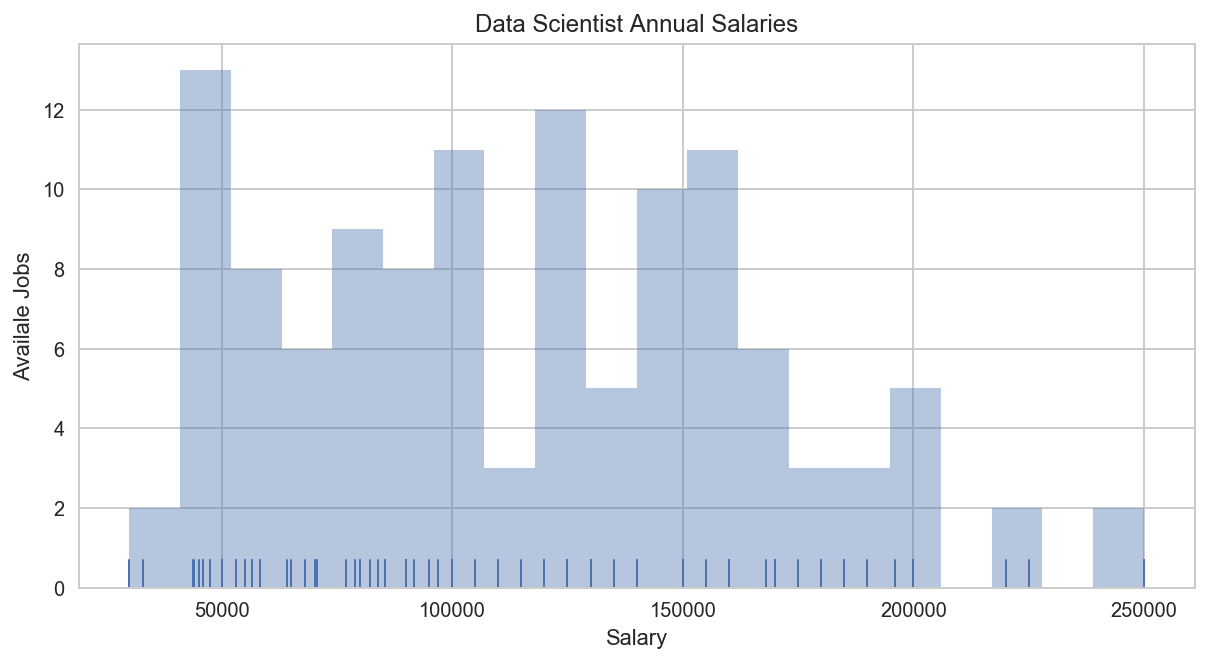

In [14]:
# Look at the distribution of the salaries
fig, ax = plt.subplots(figsize = (10, 5))
sns.distplot(df['Salary'], bins = 20, kde = False, rug = True)
ax.set(xlabel = 'Salary', ylabel = 'Availale Jobs', title = 'Data Scientist Annual Salaries')

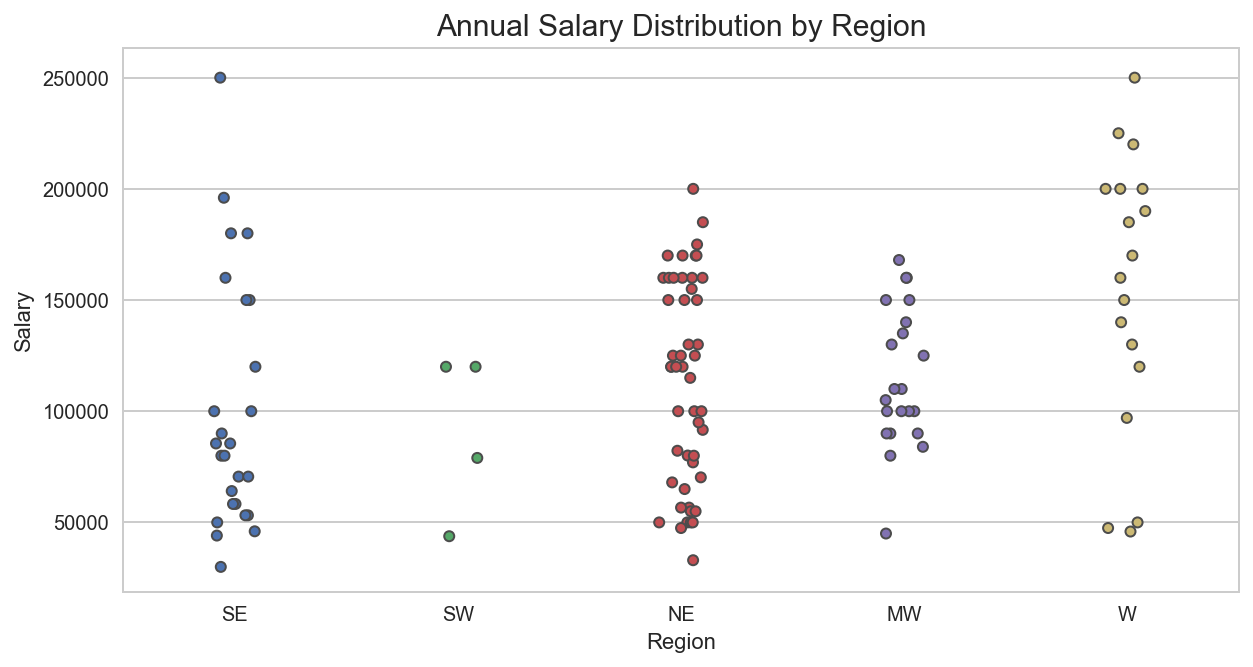

In [15]:
# Plot the range of salaries by region
plt.figure(figsize=(10, 5))
ax = sns.stripplot(x = 'Region', y = 'Salary', data = df, linewidth = 1, jitter = True)
ax.set_title('Annual Salary Distribution by Region', fontsize = 15)

NE    49
SE    26
MW    22
W     18
SW     4
Name: Region, dtype: int64


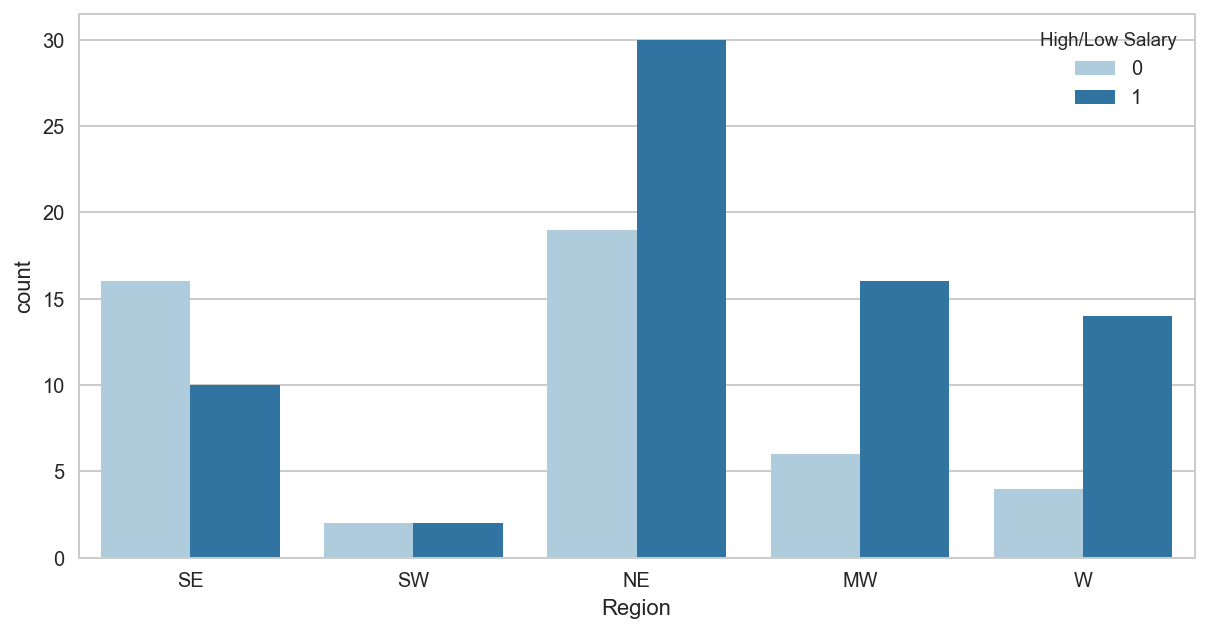

In [16]:
# Show the counts of jobs available in each region bin using based on whether the salary is high (100,000 or more) 
# or low (0 to 99,999)
plt.figure(figsize = (10, 5))
sns.countplot(x = 'Region', data = df, hue = 'High/Low Salary', palette = 'Paired')
print df.Region.value_counts()

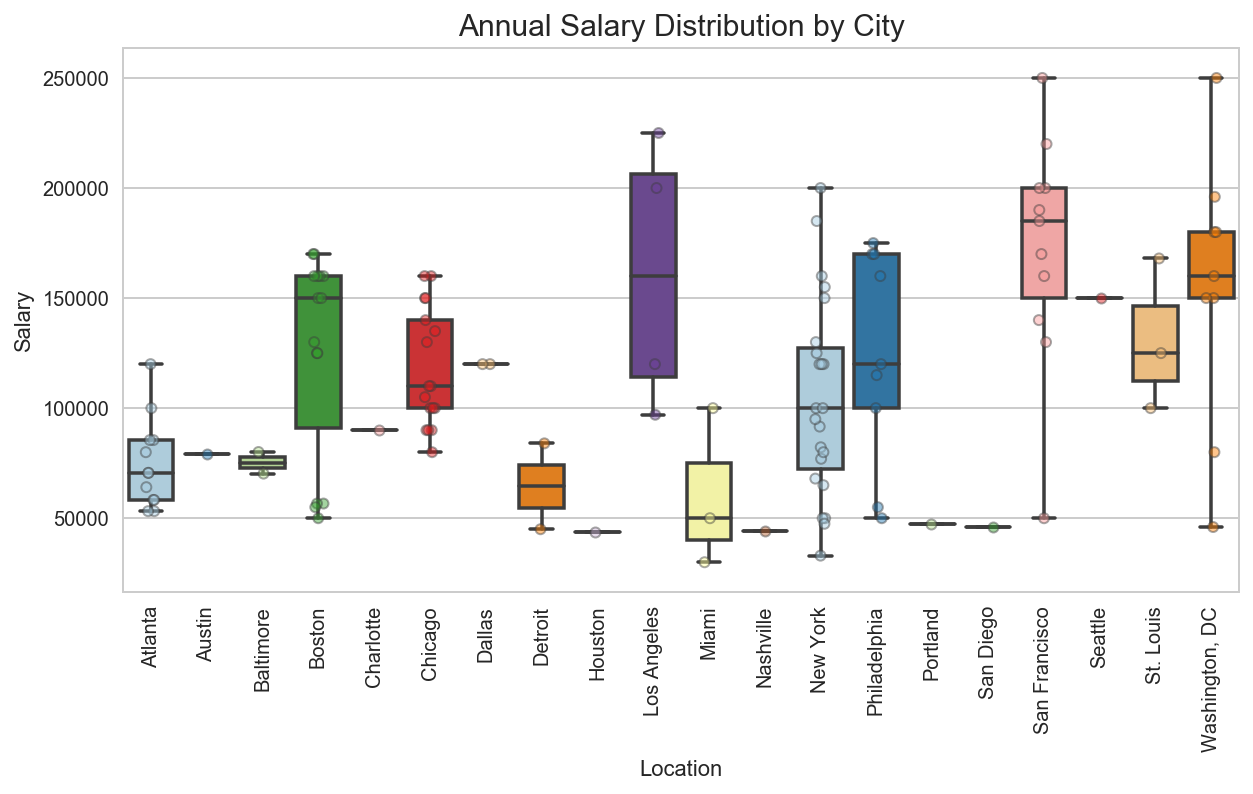

In [18]:
# Scatter plot overlaying a boxplot of the salaries by each city
plt.figure(figsize = (10, 5))
b = sns.boxplot(x = "Location", y = "Salary", data = df, whis = np.inf, palette = 'Paired')
for item in b.get_xticklabels():
    item.set_rotation(90)
b = sns.stripplot(x = 'Location', y = 'Salary', data = df, linewidth = 1, alpha = 0.45, jitter = True, 
                  palette = 'Paired')
b.set_title('Annual Salary Distribution by City', fontsize = 15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

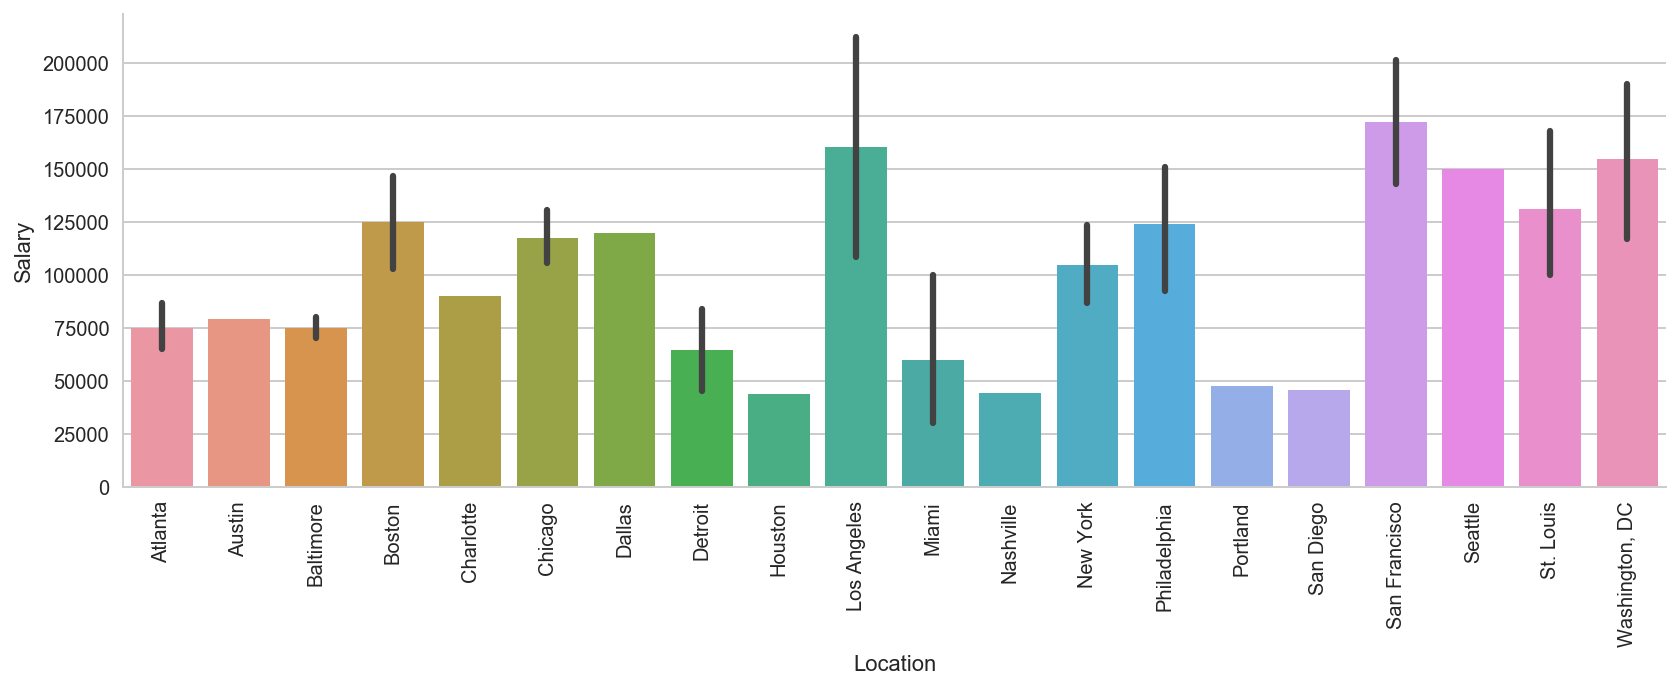

In [34]:
sns.factorplot(x = 'Location', y='Salary', 
               data=df, kind='bar', aspect=3)
plt.xticks(rotation = 90)

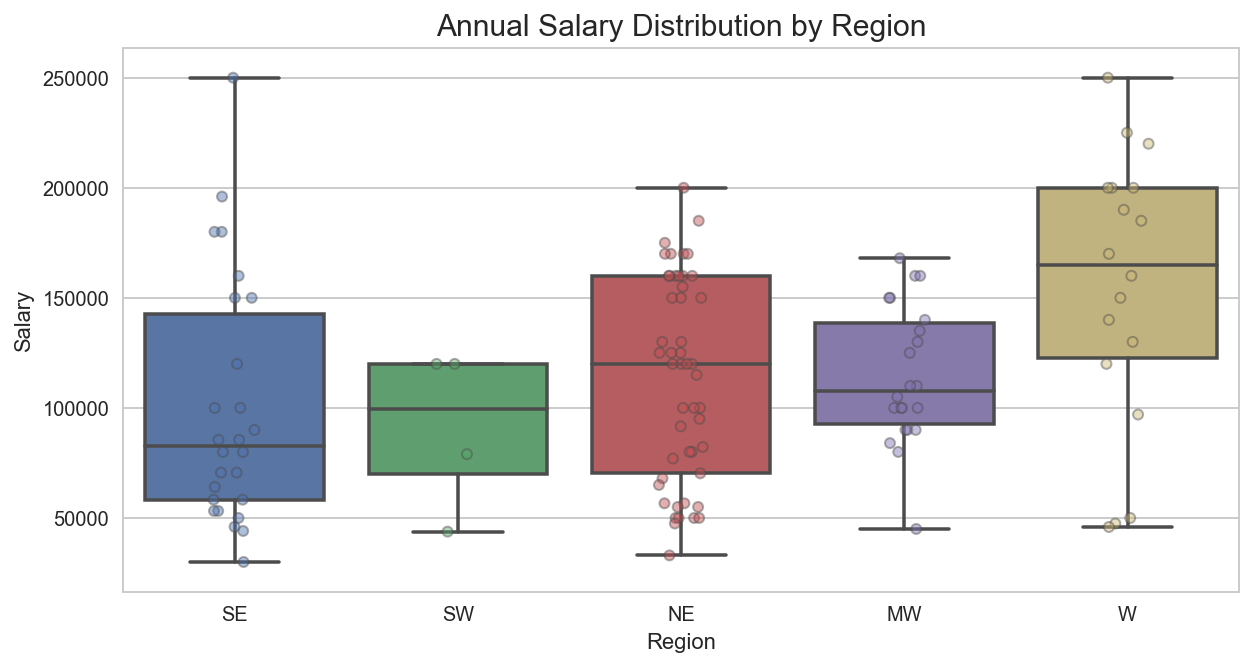

In [19]:
# Scatter plot overlaying a boxplot of the salaries by each region
plt.figure(figsize = (10, 5))
b = sns.boxplot(x = "Region", y = "Salary", data = df, whis = np.inf)
for item in b.get_xticklabels():
    item.set_rotation(0)
b = sns.stripplot(x = 'Region', y = 'Salary', data = df, linewidth = 1, alpha = 0.45, jitter = True)
b.set_title('Annual Salary Distribution by Region', fontsize = 15)

# Statistical Modeling

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import statsmodels.formula.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

## Logistic Regression (Using Logit)

In [20]:
# Establish predictor and target variables
X = pd.get_dummies(df['Region'])
y = df['High/Low Salary']

In [21]:
print 'Baseline Accuracy: ', np.mean(y)

Baseline Accuracy:  0.605042016807


In [22]:
# Logit regression using the entire dataset
logit = sm.Logit(y, X)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.632273
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        High/Low Salary   No. Observations:                  119
Model:                          Logit   Df Residuals:                      114
Method:                           MLE   Df Model:                            4
Date:                Mon, 03 Jul 2017   Pseudo R-squ.:                 0.05760
Time:                        12:21:02   Log-Likelihood:                -75.240
converged:                       True   LL-Null:                       -79.839
                                        LLR p-value:                   0.05637
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MW             0.9808      0.479      2.049      0.040       0.043       1.919
NE             0.4568      0.293      1.558      0.119      -0.118       1.031
SE            -0.4700      0.403     -1.166      0.244      -1.260       0.320
SW                  0      1.000          0      1.000      -1.960       1.960
W              1.2528      0.567      2.210      0.027       0.142       2.364
==============================================================================
"""

In [24]:
# Calculate the coefficients' 95% confidence interval range
conf_int = result.conf_int()
conf_int["Coef"] = result.params
conf_int.columns = ["2.5%", "97.5%", "Coef"]
np.exp(conf_int)

,2.5%,97.5%,Coef
MW,1.043487,6.814758,2.666667
NE,0.888786,2.805033,1.578947
SE,0.283628,1.377242,0.625000
SW,0.140863,7.099071,1.000000
W,1.152079,10.632955,3.500000


Based on the results of this classification model and the calculated coefficients for a 95% confidence interval, the odds of finding a job with a high salary in the midwest is 2.7 times greater than the baseline of 0.61.

Taking into consideration how the rest of the coefficents line up, the best odd of landing a job with a high salary is in the West (3.5 times greater) than the initial baseline.

## Decision Tree Classifier

In [25]:
# Set up testing and target variables
X = pd.get_dummies(df['Location'])
y = df['High/Low Salary']

In [26]:
DTC = DecisionTreeClassifier(max_depth = 3, min_samples_split = 50)
print DTC.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [27]:
scores = cross_val_score(DTC, X, y, cv = 10)
print 'Cross-val score: ', np.mean(scores)

Cross-val score:  0.52872960373


In [28]:
city_importance = pd.DataFrame(DTC.feature_importances_, index = X.columns, 
                               columns = ['Importance'])
city_importance.sort_values(by = 'Importance', ascending=False).head()

,Importance
Atlanta,0.59052
Baltimore,0.20864
Detroit,0.20084
Nashville,0.00000
St. Louis,0.00000


## Random Forest Classifer

In [29]:
# Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.75)

RFC = RandomForestClassifier(n_estimators = 250)
RFC.fit(X_train, y_train)
predictions = RFC.predict(X_test)

In [30]:
rfc_pr = RFC.predict(X_test)
score = accuracy_score(y_test, rfc_pr)
print 'Accuracy score: ',score

Accuracy score:  0.655555555556


In [31]:
feat_imp = pd.DataFrame(RFC.feature_importances_, index = X.columns, columns = ['importance'])

feat_imp.sort_values(by = 'importance', ascending = False).head()

,importance
Detroit,0.183123
"Washington, DC",0.102694
Nashville,0.091391
New York,0.088288
Miami,0.085703


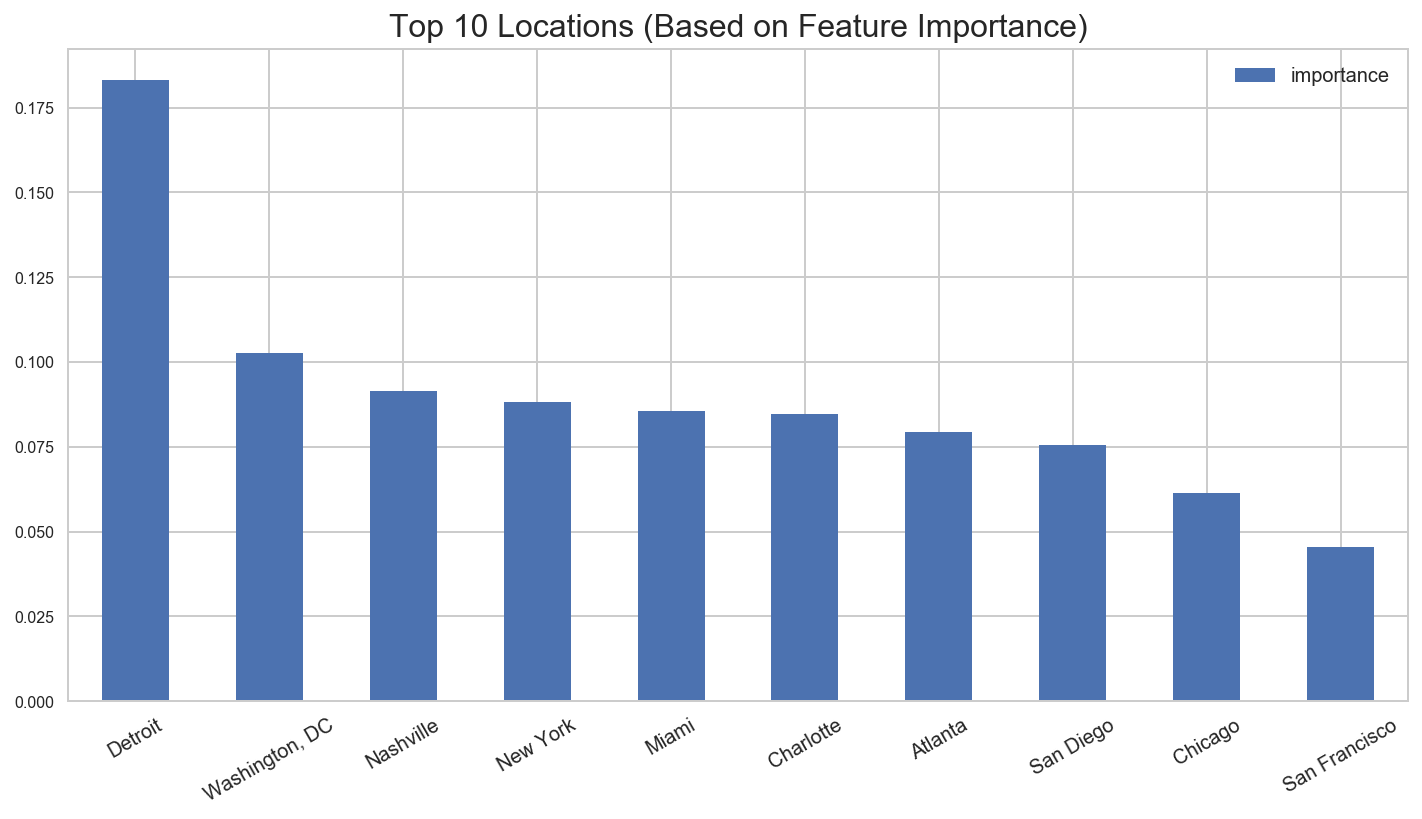

In [35]:
# Plot the 10 locations with the highest feature impotance values
fig, ax = plt.subplots(figsize=(12,6))
feat_imp.sort_values(by = 'importance', ascending=False).head(10).plot(
    kind = 'bar', ax = ax, fontsize = 8)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize = 10, rotation = 30)
ax.set_title('Top 10 Locations (Based on Feature Importance)',fontsize = 16)
plt.show()

The Decision Tree and Random Forest Models show that region or location alone are not the sole features that determines whether or not the salary of a position will be over 100,000. From the graphical EDA, we saw that the majority of high paying jobs are in the West, however, from the Decision Tree and Random Forest results, the locations that had the highest importance were in the eastern-most regions.

## Presentation Link

http://prezi.com/enrewpyds_p-/?utm_campaign=share&utm_medium=copy